Initial Imports

In [70]:
import tensorflow as tf
import pandas as pd
import random as rd
import matplotlib.pyplot as plt
import os
import numpy as np
from tensorflow.keras import layers

Data Extraction

In [71]:
# Using a reduced version of the data
df = pd.read_csv("tweets-reduced.csv", encoding="ISO-8859-1", header=None)
df.columns = ["target", "id", "datetime", "flag", "user", "text"]
df.head()

,target,id,datetime,flag,user,text
0,0,2285370474,Mon Jun 22 15:02:48 PDT 2009,NO_QUERY,idmoore,"@Opotopo small slip on Tryfan few weeks back, ..."
1,0,2285370823,Mon Jun 22 15:02:49 PDT 2009,NO_QUERY,xbeautifulmessx,@Idristwilight You can post HAN when you want....
2,0,2285371185,Mon Jun 22 15:02:51 PDT 2009,NO_QUERY,thefirstsight,@rose_7 Ohh poor jan please tell her that if ...
3,0,2285371495,Mon Jun 22 15:02:52 PDT 2009,NO_QUERY,Sarah2713,Finally home from work...It was a looong day!!...
4,0,2285371762,Mon Jun 22 15:02:54 PDT 2009,NO_QUERY,dierockerfrau,im very sad 4 chantelle and tom


Data Exploration

In [72]:
df.target.value_counts()

target
0    50000
4    50000
Name: count, dtype: int64

In [73]:
df.text.sample(1).iloc[0]

"Just bopping in the kitchen to Human League's Greatest Hits on the iPod. I almost feel young again  Kids thought I was having a fit "

Data cleaning and preprocessing

In [74]:
df["split_text"] = [val.split() for val in df.text]
df.head()

,target,id,datetime,flag,user,text,split_text
0,0,2285370474,Mon Jun 22 15:02:48 PDT 2009,NO_QUERY,idmoore,"@Opotopo small slip on Tryfan few weeks back, ...","[@Opotopo, small, slip, on, Tryfan, few, weeks..."
1,0,2285370823,Mon Jun 22 15:02:49 PDT 2009,NO_QUERY,xbeautifulmessx,@Idristwilight You can post HAN when you want....,"[@Idristwilight, You, can, post, HAN, when, yo..."
2,0,2285371185,Mon Jun 22 15:02:51 PDT 2009,NO_QUERY,thefirstsight,@rose_7 Ohh poor jan please tell her that if ...,"[@rose_7, Ohh, poor, jan, please, tell, her, t..."
3,0,2285371495,Mon Jun 22 15:02:52 PDT 2009,NO_QUERY,Sarah2713,Finally home from work...It was a looong day!!...,"[Finally, home, from, work...It, was, a, looon..."
4,0,2285371762,Mon Jun 22 15:02:54 PDT 2009,NO_QUERY,dierockerfrau,im very sad 4 chantelle and tom,"[im, very, sad, 4, chantelle, and, tom]"


In [75]:
clean_df = df.drop(columns=["id", "datetime", "flag", "user"])
clean_df.target /= 4
clean_df.head()

,target,text,split_text
0,0.0,"@Opotopo small slip on Tryfan few weeks back, ...","[@Opotopo, small, slip, on, Tryfan, few, weeks..."
1,0.0,@Idristwilight You can post HAN when you want....,"[@Idristwilight, You, can, post, HAN, when, yo..."
2,0.0,@rose_7 Ohh poor jan please tell her that if ...,"[@rose_7, Ohh, poor, jan, please, tell, her, t..."
3,0.0,Finally home from work...It was a looong day!!...,"[Finally, home, from, work...It, was, a, looon..."
4,0.0,im very sad 4 chantelle and tom,"[im, very, sad, 4, chantelle, and, tom]"


<Axes: ylabel='Frequency'>

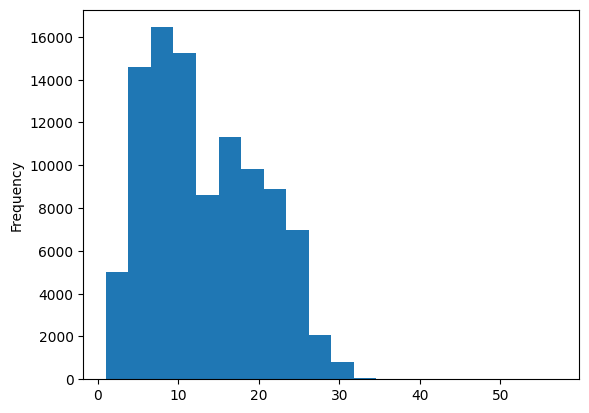

In [76]:
clean_df["length"] = [len(val) for val in clean_df.split_text]
clean_df.length.plot(kind="hist", bins=20)

In [77]:
np.round(clean_df.length.mean())

13.0

In [78]:
np.percentile(clean_df.length, 75)

19.0

In [79]:
from sklearn.model_selection import train_test_split

X = clean_df["text"]
y = clean_df["target"]

x_train, x_t, y_train, y_t = train_test_split(X, y, test_size=0.2, random_state=42)
x_val, y_val = x_t[::2], y_t[::2]
x_test, y_test = x_t[1::2], y_t[1::2]
x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_test.shape, y_val.shape

((80000,), (10000,), (10000,), (80000,), (10000,), (10000,))

Model Evaluation

In [80]:
def make_preds(model, data):
    preds = model.predict(data, verbose=0)
    preds = np.squeeze(np.round(preds))
    return preds

In [81]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def eval_results(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)

  precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1}
  return model_results

Model 0

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(X=x_train,
            y=y_train)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [83]:
model_0.score(x_test, y_test)

0.7862

In [84]:
model_0_preds = model_0.predict(x_test)
model_0_results = eval_results(y_test, model_0_preds)
model_0_results

{'accuracy': 0.7862,
 'precision': 0.7903277553750947,
 'recall': 0.7862,
 'f1': 0.7855366363442661}

Numerical Encoding

In [85]:
max_vocab_length = 10000
max_length = 20

text_vectorizer = layers.TextVectorization(
    max_tokens=max_vocab_length,
    output_sequence_length=max_length,
    output_mode="int"
)

In [86]:
text_vectorizer.adapt(x_train)
print(x_train[0])
print(text_vectorizer([x_train[0]]))

@Opotopo small slip on Tryfan few weeks back, felt side pull but didnt think it was bad. Muscle went between ribs. Did me for 2 weeks 
tf.Tensor(
[[   1  861 5278   15    1  288  382   55  920  607 2336   20  118   72
    10   27  108 2515  216  965]], shape=(1, 20), dtype=int64)


In [87]:
text_vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'i', 'to', 'the']

In [88]:
embedding = layers.Embedding(
    input_dim=max_vocab_length,
    input_length=max_length,
    output_dim=128
)

Model 1

In [89]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 20)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 20, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 1280129 (4.

In [90]:
hist_1 = model_1.fit(
    x_train,
    y_train,
    epochs=3,
    validation_data=(x_val, y_val)
)

Epoch 1/3
2500/2500 [==============================] - 28s 11ms/step - loss: 0.5108 - accuracy: 0.7593 - val_loss: 0.4576 - val_accuracy: 0.7886
Epoch 2/3
2500/2500 [==============================] - 24s 10ms/step - loss: 0.4328 - accuracy: 0.8073 - val_loss: 0.4591 - val_accuracy: 0.7858
Epoch 3/3
2500/2500 [==============================] - 25s 10ms/step - loss: 0.4137 - accuracy: 0.8167 - val_loss: 0.4625 - val_accuracy: 0.7859


In [91]:
model_1_preds = make_preds(model_1, x_test)
model_1_results = eval_results(y_test, model_1_preds)
model_1_results

{'accuracy': 0.7878,
 'precision': 0.7890847576257486,
 'recall': 0.7878,
 'f1': 0.7875060778740877}

Model 2

In [94]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64)(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 20)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 20, 128)           1280000   
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                           

In [95]:
hist_2 = model_2.fit(
    x_train,
    y_train,
    epochs=3,
    validation_data=(x_val, y_val)
)

Epoch 1/3
2500/2500 [==============================] - 37s 14ms/step - loss: 0.3761 - accuracy: 0.8314 - val_loss: 0.4355 - val_accuracy: 0.7988
Epoch 2/3
2500/2500 [==============================] - 37s 15ms/step - loss: 0.3438 - accuracy: 0.8479 - val_loss: 0.4524 - val_accuracy: 0.7974
Epoch 3/3
2500/2500 [==============================] - 40s 16ms/step - loss: 0.3074 - accuracy: 0.8637 - val_loss: 0.4887 - val_accuracy: 0.7945


In [96]:
model_2_preds = make_preds(model_2, x_test)
model_2_results = eval_results(y_test, model_2_preds)
model_2_results

{'accuracy': 0.7924,
 'precision': 0.7929466245600337,
 'recall': 0.7924,
 'f1': 0.7923366930452447}

Model 3

In [97]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 20)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 20, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 16, 64)            41024     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_5 (Dense)             (None, 64)                4160

In [98]:
hist_3 = model_3.fit(
    x_train,
    y_train,
    epochs=3,
    validation_data=(x_val, y_val)
)

Epoch 1/3
2500/2500 [==============================] - 29s 11ms/step - loss: 0.3479 - accuracy: 0.8431 - val_loss: 0.4590 - val_accuracy: 0.7915
Epoch 2/3
2500/2500 [==============================] - 28s 11ms/step - loss: 0.2906 - accuracy: 0.8716 - val_loss: 0.5201 - val_accuracy: 0.7921
Epoch 3/3
2500/2500 [==============================] - 28s 11ms/step - loss: 0.2294 - accuracy: 0.9013 - val_loss: 0.6095 - val_accuracy: 0.7874


In [99]:
model_3_preds = make_preds(model_3, x_test)
model_3_results = eval_results(y_test, model_3_preds)
model_3_results

{'accuracy': 0.7824,
 'precision': 0.7826238078025357,
 'recall': 0.7824,
 'f1': 0.7823796315841013}

Model 4

In [100]:
# Requires over 900MB to download the pre-trained embeddings from TensorflowHub
import tensorflow_hub as hub

use = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], dtype=tf.string, trainable=False)

model_4 = tf.keras.Sequential([
    use,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model_4.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_4.summary()

In [101]:
hist_4 = model_4.fit(
    x_train,
    y_train,
    epochs=3,
    validation_data=(x_val, y_val)
)

In [102]:
model_4_preds = make_preds(model_4, x_test)
model_4_results = eval_results(y_test, model_4_preds)
model_4_results